In [13]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import exponnorm
from user_parameters import *
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks, peak_widths
import math
from peak_finding import *

## Create Baseline with noise

Let's suppose that the baseline noise depends only on solvent composition, and that due to zeroing during a non-included equilibrium phase, the initial 

In [2]:
# gradient_table = pd.read_csv("./gradients.csv")
# gradient_table.head()

### Create Baseline

First, we get the maximum time from the gradient table, and then use this value and the `SAMPLE_RATE` from `general_parameters` to generate time and signal arrays.

In [4]:
max_time = RUN_LENGTH

samples_per_minute = 60 * SAMPLE_RATE

times = np.arange(0, max_time, 1./samples_per_minute)
signal = np.random.normal(loc = 0, scale = BASELINE_NOISE, size = times.shape)
signal = savgol_filter(signal, 15, 3)

## Load peaks table

In [7]:
from peaks import peaks as peaks_list
peaks_list

[{'name': 'toluene',
  'time': 0.954887466720803,
  'height': 59.64893942142677,
  'width': 0.07720796097712378,
  'asymmetry': 0.9669826017862847},
 {'name': 'benzene',
  'time': 1.7482461957507476,
  'height': 124.47036588742765,
  'width': 0.07782113763175734,
  'asymmetry': 0.9639185953952437},
 {'name': '4-butylphenol',
  'time': 2.4444940107993305,
  'height': 512.9646535122713,
  'width': 0.07836273275360321,
  'asymmetry': 0.9612402787255006},
 {'name': 'thymol',
  'time': 5.088052141120832,
  'height': 431.99404032839874,
  'width': 0.0804509105236806,
  'asymmetry': 0.9511516327262306},
 {'name': 'carvacrol',
  'time': 5.515263239786657,
  'height': 398.1525031825023,
  'width': 0.08079426076453675,
  'asymmetry': 0.949527896756071},
 {'name': '2-isopropylphenol',
  'time': 5.945655647842379,
  'height': 99.57061926309787,
  'width': 0.1804346917687321,
  'asymmetry': 0.9476420851901262},
 {'name': 'phenethyl alcohol',
  'time': 9.10696661054843,
  'height': 119.3248120767891

## Create Signal for Peaks

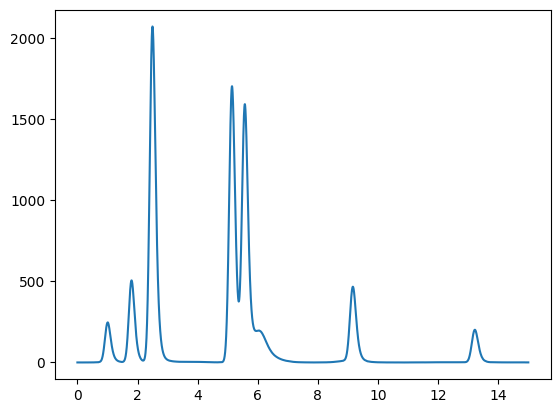

In [8]:
for peak in peaks_list:
    signal += peak["height"] * exponnorm.pdf(times, K = peak["asymmetry"], loc = peak["time"], scale = peak["width"])

plt.plot(times, signal)
plt.show()


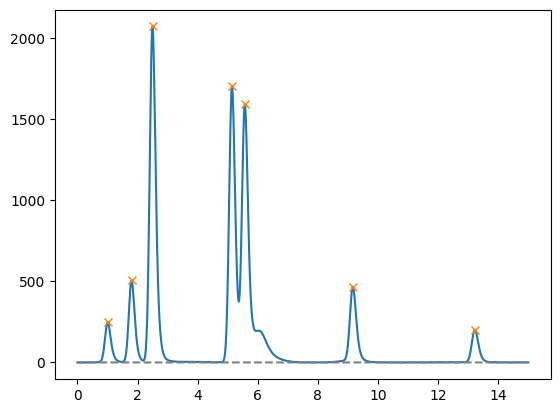

In [15]:
from scipy.signal import find_peaks, peak_widths
peaks, _ = find_peaks(signal, height=signal.max()/100, prominence = signal.max()/200, distance = SAMPLE_RATE * 10)
plt.plot(times, signal)

plt.plot(times[peaks], signal[peaks], "x")

plt.plot(times, np.zeros_like(signal), "--", color="gray")

plt.show()

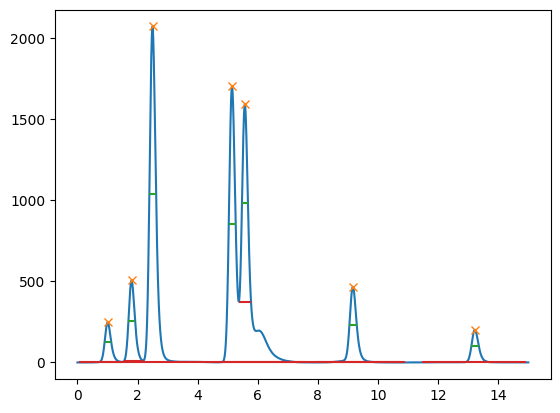

In [16]:
peak_widths(signal, peaks)

results_half = peak_widths(signal, peaks, rel_height=0.5)
results_full = peak_widths(signal, peaks, rel_height=1)
plt.plot(times, signal)

plt.plot(times[peaks], signal[peaks], "x")

num_points = SAMPLE_RATE * 60

plt.hlines(results_half[1], results_half[2]/num_points, results_half[3]/num_points, color="C2")

plt.hlines(results_full[1], results_full[2]/num_points, results_full[3]/num_points, color="C3")
# plt.hlines(*results_full[1:], color="C3")

plt.show()

## Finding good minima

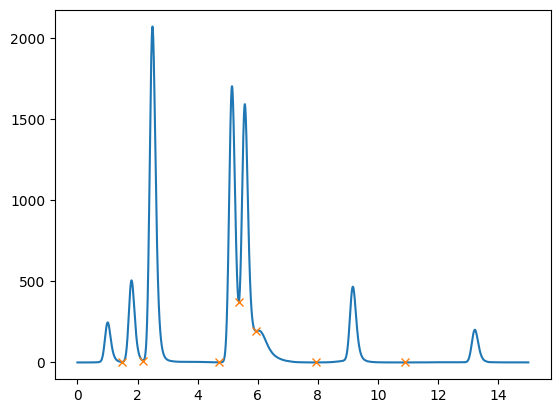

In [18]:
inv_signal = signal.max() - signal

minima, _ = find_peaks(inv_signal, 
                      height=signal.max()/100, 
                      prominence = signal.max()/1000, 
                      distance = SAMPLE_RATE * 10)
plt.plot(times, signal)

plt.plot(times[minima], signal[minima], "x")

plt.show()

## Estimate gaussians

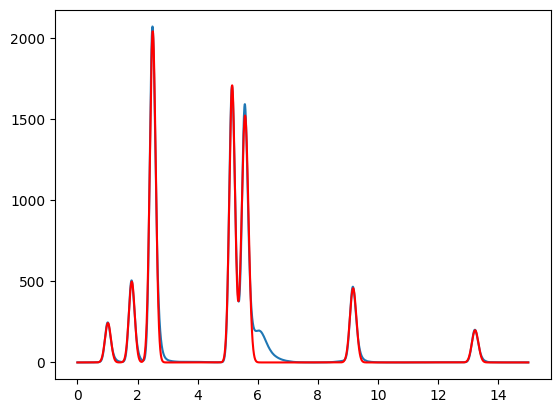

In [20]:
means = times[peaks]
sigmas = ((results_half[3] - results_half[2])/num_points)/(2 * math.sqrt(2 * math.log(2)))
heights = signal[peaks] / (math.sqrt(2 * math.pi)) * .67

from scipy.stats import norm

def gaussian_pdf(x, height = 1, scale = 1, loc = 0):
    return height / (scale * math.sqrt(2*math.pi)) * math.exp(-.5 * ((x - loc)/scale) ** 2)

def fitted_spectrum(x, *args):
    """
    Args expected in form of [*heights, *times, *sigmas]
    """
    y = np.zeros_like(x)
    num_gaussians = int(len(args)/3)
    for i in range(0, num_gaussians):
        h, t, s  = args[i], args[i+ num_gaussians], args[i + 2*num_gaussians]
        y += np.array([gaussian_pdf(a, height = h, scale = s, loc = t) for a in x])
    return y

initial_guess = np.array([*heights, *means, *sigmas])

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f = fitted_spectrum, xdata = times, ydata = signal, p0 = initial_guess )

plt.plot(times, signal)
plt.plot(times, fitted_spectrum(times, *popt), label="Fitted Curve", color='red')
plt.show()

In [10]:
d_signal1 = savgol_filter(signal[:-2]-signal[1:-1], 25, 3)
d_signal2 = savgol_filter(signal[1:-1]-signal[2:], 25, 3)
d2_signal = savgol_filter(d_signal1 - d_signal2, 25, 3)
d2_signal = savgol_filter(d2_signal, 25, 3)
dt = times[1:-1]

height_param = 20



In [11]:
## Find Noise

In [43]:
min_t = 11
max_t = 12
signals_in_range = d2_signal[round(min_t * samples_per_minute):round(max_t * samples_per_minute)]
noise_sd = np.std(signals_in_range)

threshhold = 5*noise_sd

crossings = []

for i in range(int(samples_per_minute/60),len(d2_signal)-int(samples_per_minute/60)):
    if (d2_signal[i] > threshhold and d2_signal[i-1] <= threshhold) or (d2_signal[i] < threshhold and d2_signal[i-1] >= threshhold):
        crossings.append((i/samples_per_minute, 1))
    if (d2_signal[i] > -threshhold and d2_signal[i-1] <= -threshhold) or (d2_signal[i] < -threshhold and d2_signal[i-1] >= -threshhold):
        crossings.append((i/samples_per_minute, -1))
        
crossings
        
# plt.show()

[(0.7333333333333333, 1),
 (0.9116666666666666, 1),
 (0.92, -1),
 (1.09, -1),
 (1.1033333333333333, 1),
 (1.2833333333333334, 1),
 (1.2966666666666666, 1),
 (1.3216666666666668, 1),
 (1.5133333333333334, 1),
 (1.7083333333333333, 1),
 (1.7116666666666667, -1),
 (1.8866666666666667, -1),
 (1.8916666666666666, 1),
 (2.4066666666666667, 1),
 (2.4066666666666667, -1),
 (2.5866666666666664, -1),
 (2.5883333333333334, 1),
 (2.965, 1),
 (4.803333333333334, 1),
 (5.046666666666667, 1),
 (5.048333333333333, -1),
 (5.23, -1),
 (5.2316666666666665, 1),
 (5.476666666666667, 1),
 (5.4783333333333335, -1),
 (5.656666666666666, -1),
 (5.658333333333333, 1),
 (5.96, 1),
 (6.008333333333334, -1),
 (6.013333333333334, -1),
 (6.031666666666666, -1),
 (6.14, -1),
 (6.161666666666667, -1),
 (6.181666666666667, -1),
 (8.856666666666667, 1),
 (9.061666666666667, 1),
 (9.068333333333333, -1),
 (9.255, -1),
 (9.263333333333334, 1),
 (9.528333333333334, 1),
 (12.945, 1),
 (13.113333333333333, 1),
 (13.123333333

In [47]:
crossing_count = 0
cleaned_crossings  = []
ind = 0
while ind < len(crossings):
    crossing = crossings[ind]
    crossing_type = crossing[1]
    if crossing_count == 2 and crossing_type == 1:
        #count ones ahead
        ahead_count = 0
        ahead_ind = ind + 1
        while ahead_ind < length(crossings):
            if crossings[ahead_ind][1] == 1:
                ahead_ind += 1
                ahead_count += 1
            else:
                break 
        if ahead_count > 2:
            ind = ahead_ind - 2
    else:
        ind += 1
    cleaned_crossings.append(crossing)
        
cleaned_crossings        

[(0.7333333333333333, 1),
 (0.9116666666666666, 1),
 (0.92, -1),
 (1.09, -1),
 (1.1033333333333333, 1),
 (1.2833333333333334, 1),
 (1.2966666666666666, 1),
 (1.3216666666666668, 1),
 (1.5133333333333334, 1),
 (1.7083333333333333, 1),
 (1.7116666666666667, -1),
 (1.8866666666666667, -1),
 (1.8916666666666666, 1),
 (2.4066666666666667, 1),
 (2.4066666666666667, -1),
 (2.5866666666666664, -1),
 (2.5883333333333334, 1),
 (2.965, 1),
 (4.803333333333334, 1),
 (5.046666666666667, 1),
 (5.048333333333333, -1),
 (5.23, -1),
 (5.2316666666666665, 1),
 (5.476666666666667, 1),
 (5.4783333333333335, -1),
 (5.656666666666666, -1),
 (5.658333333333333, 1),
 (5.96, 1),
 (6.008333333333334, -1),
 (6.013333333333334, -1),
 (6.031666666666666, -1),
 (6.14, -1),
 (6.161666666666667, -1),
 (6.181666666666667, -1),
 (8.856666666666667, 1),
 (9.061666666666667, 1),
 (9.068333333333333, -1),
 (9.255, -1),
 (9.263333333333334, 1),
 (9.528333333333334, 1),
 (12.945, 1),
 (13.113333333333333, 1),
 (13.123333333

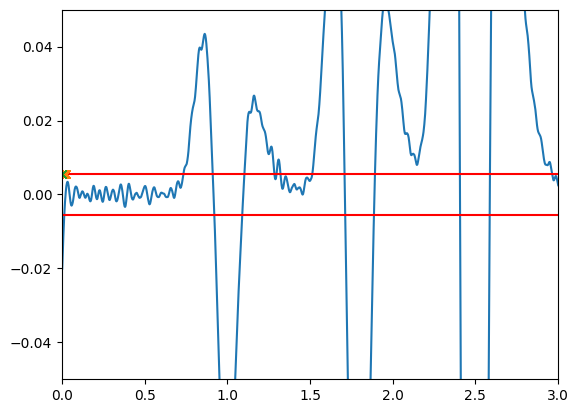

In [36]:
plt.plot(dt, d2_signal)
plt.hlines(threshhold, 0, times.max(), color="red")
plt.hlines(-threshhold, 0, times.max(), color="red")

plt.plot(np.array(crossings) / samples_per_minute, np.zeros_like(crossings) + threshhold, "x")

plt.ylim(-.05, 0.05)
plt.xlim(0, 3)


colors = np.zeros_like(d2_signal)

## Curve Fitting to Find Peaks

The ideal chromatography peak is gaussian, with a signal 
$$
y = h e ^{- \frac{(t - R_t)^2}{2 \sigma^2}}
$$
where $h$ is the peak height, $R_t$ is the retention time, and $\sigma$ is the statistical standard deviation of the peak. However, for various reasons (e.g. column packing heterogeneity, analyte/solvent interactions, environmental conditions), there is usually some degree of tailing of peaks, and we see a deviation from the ideal gaussian. Instead, chromatography peaks are often more similar to exponentially modified gaussians; these distrubutions describe the sum of independent normal and exponential distrubutions. 

$(fg)'(x) = \left(-\frac{\lambda^2}{2} e^{\frac{\lambda}{2} (2\mu + \lambda\sigma^2 - 2x)}\right) \cdot \left(\text{erfc}\left(\frac{\mu + \lambda\sigma^2 - x}{\sqrt{2}\sigma}\right)\right) + \left(\frac{\lambda}{2} e^{\frac{\lambda}{2} (2\mu + \lambda\sigma^2 - 2x)}\right) \cdot \left(\frac{1}{\sqrt{\pi}} \frac{e^{-\left(\frac{\mu + \lambda\sigma^2 - x}{\sqrt{2}\sigma}\right)^2}}{\sqrt{2}\sigma}\right)$